### Data -- Wait time stats actual view

In [50]:
# pip install psycopg2
#!pip install snowflake
#!pip install lightgbm
#!pip install gtfs-realtime-bindings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import psycopg2
from datetime import datetime
import requests
from datetime import date
from datetime import timedelta
import snowflake.connector

In [51]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user='SPARK',
    authenticator = "externalbrowser",
    account='BROOKLYNSPORTSANDENTERTAINMENT-BSEGLOBAL',  # e.g., xy12345.us-east-1
    warehouse='All Too Ware',
    database='BSEDW',
    schema='WAITTIME', 
    role = "SNOWFLAKE_DOMINATEAI"
)
cursor = conn.cursor()
# Explicitly activate the warehouse
cursor.execute('USE WAREHOUSE "All Too Ware"')

# Query data
query = "SELECT * FROM WAITTIME_STATSACTUALVIEW where EVENT_DATE <= '2025-07-27'"
cursor.execute(query)

# Convert to pandas DataFrame
df = cursor.fetch_pandas_all()

# Close the connection
cursor.close()
conn.close()

# Display results
print(df.head())


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://bseglobal.okta.com/app/snowflake/exkqh96ogn06lUM3g4x7/sso/saml?SAMLRequest=rZNdc%2BIgFIb%2FSoa9TsBvZdSOrWObbu3aGnvRO5JgZCSQcojR%2Fvolfk33or3aOwbew%2FOe88LwZp9Lb8cNCK1GqBEQ5HGV6FSobIRW0czvIw8sUymTWvEROnBAN%2BMhsFwWdFLajXrlHyUH67mLFND6YIRKo6hmIIAqlnOgNqHLyfyJNgNCGQA31uHQuSQF4VgbawuKcVVVQdUKtMlwkxCCyQA7VS35hb4gip8ZhdFWJ1peSvaup28QDUzaNcIpHGFxLrwV6jSCnyjxSQT0IYoW%2FuLPMkLe5NLdnVZQ5twsudmJhK9en04GwDmIjdZbeVBQaGPBDZcr66qYULlb%2BTHwTOqYyQCUrtaSbXmi86K0Dha4FV7zFEudCTfCcDpCxVakBqLPh938sRvGj%2FnnIH22kZ6KQ3v3O3y5V%2FcyZvF7KyRtNntJkPd2CbxZBx4ClDxUdczWbZFmxyd9n%2FSiRpN2%2BrQ1CEiv8468qYtZKGaPlddermb11rKjPVYU%2BOoc8%2F32YzPo6kyRrlzNW1l738MAGtc5otNTokcLZvyfBjTEXy89P9Znl184XWgpkoM30yZn9vt4G0HjuCNSf32UUp4zISdpajiAi1lKXd0Zzqz7E9aUHOHxifrvrxj%2FBQ%3D%3D

In [52]:
# Convert all column names to lowercase
df.columns = df.columns.str.lower()

In [53]:
needed_columns = ['event_name',
'event_name_long',
'event_date',
'event_time',
'event_day',
'starttime',
'team',
'minor_category',
'property',
'numberinline',
'relative start (minutes)',
'wait time (minutes)',
'time category']

df = df[needed_columns]

In [54]:
# CSV
df.to_csv('wait time_v3._barclays.csv', index=False)  

In [55]:
# Convert times 
df['event_date'] = pd.to_datetime(df['event_date'])
df['starttime'] = pd.to_datetime(df['starttime'], errors='coerce')
df['event_time'] = pd.to_datetime(df['event_time'], format='%H:%M:%S').dt.time

# Note: relative start (minutes) should already be calculated in the source data
# If it's missing, we would need the actual timestamp column to compute it

In [56]:
# Remove upsell or irrelevant events
df = df[~(df['event_name_long'].str.contains("Upsell", na=False) | 
          df['event_name_long'].str.contains("CANCELED", na=False) |
          df['event_name_long'].str.contains("Cancelled", na=False) |
          df['event_name_long'].str.contains("Libs for Kids 2023 Holding Event", na=False) |
          df['event_name_long'].str.contains("Test", na=False) |
          df['team'].str.contains("Test", case=False, na=False))]

# Drop nulls in critical columns
df = df.dropna(subset=['relative start (minutes)', 'wait time (minutes)', 'numberinline'])

In [57]:
# Verify that test - brooklyn nets rows are removed
test_rows = df[df['team'].str.contains("test", case=False, na=False)]
print(f"Rows with 'test' in team name after filtering: {len(test_rows)}")
if len(test_rows) > 0:
    print("Teams still containing 'test':")
    print(test_rows['team'].value_counts())
else:
    print("✓ Successfully removed all rows with 'test' in team name")

Rows with 'test' in team name after filtering: 0
✓ Successfully removed all rows with 'test' in team name


### Relative start time cutoffs

In [58]:
# Print minimum and maximum event_date
print('Minimum event_date:', df['event_date'].min())
print('Maximum event_date:', df['event_date'].max())

Minimum event_date: 2023-09-01 00:00:00
Maximum event_date: 2025-07-26 00:00:00


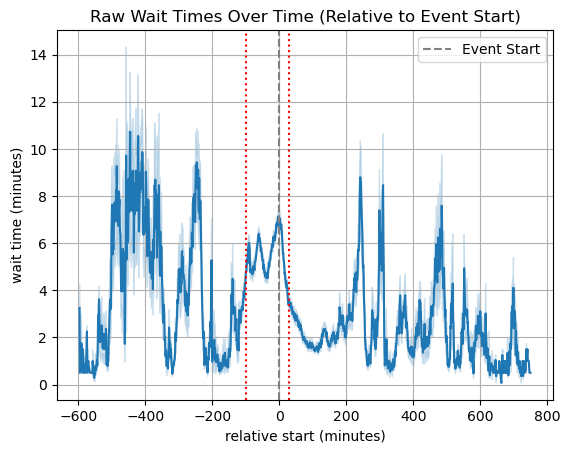

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=df, x='relative start (minutes)', y='wait time (minutes)')
plt.title("Raw Wait Times Over Time (Relative to Event Start)")
plt.axvline(0, linestyle='--', color='gray', label='Event Start')
plt.axvline(-100, linestyle=':', color='red')
plt.axvline(30, linestyle=':', color='red')
plt.legend()
plt.grid(True)
plt.show()


In [60]:
# Round to nearest minute
df['relative start (minutes)'].astype(int) 

# Filter out after-event tail if not useful
df = df[df['relative start (minutes)'] <= 30] # Operataional cutoff 
df = df[df['relative start (minutes)'] >= -100]

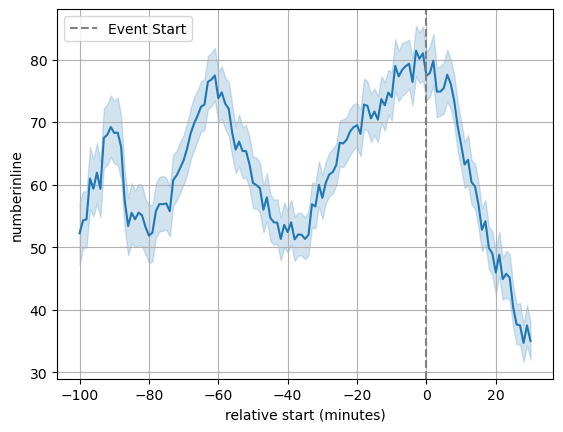

In [61]:
sns.lineplot(data=df, x='relative start (minutes)', y='numberinline')
plt.axvline(0, linestyle='--', color='gray', label='Event Start')
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# 5 minute buckets 
df['5_minute_bucket'] = (df['relative start (minutes)'] // 5) * 5

### Queue trend with numberline

In [63]:
# Adding queue trend features (when lines are accelearating or decelerating)
df = df.sort_values(['event_name','relative start (minutes)'])

# 3-minute rolling mean -- congestion at specific times 
df['queue_mean_3'] = (
    df.groupby('event_name')['numberinline']
      .transform(lambda s: s.rolling(window=3, min_periods=1).mean())
)

df['day_of_week'] = df['event_date'].dt.dayofweek

# 3-minute rolling slope (simple linear trend) -- accelration or deceleration of queue
def _slope(a):
    idx = np.arange(len(a))
    return np.polyfit(idx, a, 1)[0]  # coefficient of x

df['queue_slope_3'] = (
    df.groupby('event_name')['numberinline']
      .transform(lambda s: s.rolling(window=3, min_periods=2).apply(_slope, raw=True))
      .fillna(0)
)


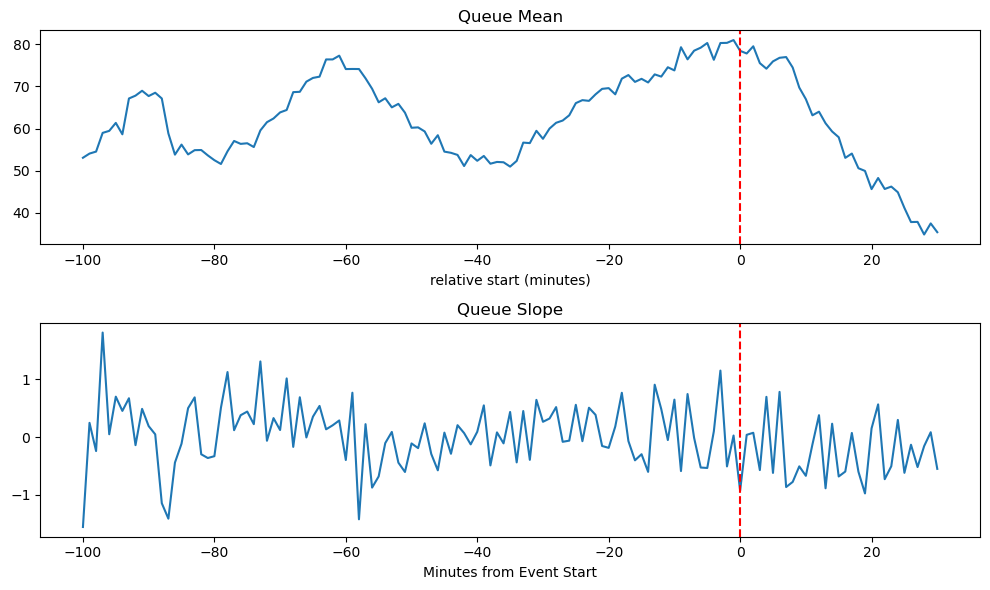

In [64]:
# Combined plot
plt.figure(figsize=(10, 6))
plt.subplot(2,1,1)
df.groupby('relative start (minutes)')['queue_mean_3'].mean().plot()
plt.title('Queue Mean')
plt.axvline(0, color='red', linestyle='--')

plt.subplot(2,1,2)
df.groupby('relative start (minutes)')['queue_slope_3'].mean().plot()
plt.title('Queue Slope')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Minutes from Event Start')

plt.tight_layout()
plt.show()

### Cyclical

In [65]:
# Add cyclical time features for better modeling
df['hour'] = pd.to_datetime(df['event_time'], format='%H:%M:%S').dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Day of week cyclical encoding
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Minute bucket cyclical encoding (for within-event timing)
df['minute_sin'] = np.sin(2 * np.pi * df['relative start (minutes)'] / 30)  # 30 minute cycle
df['minute_cos'] = np.cos(2 * np.pi * df['relative start (minutes)'] / 30)

### Attendance 

In [66]:
# Attendence counts 
def run_query():
#Connect with the database
    DW_HOST = "172.22.12.130"
    DW_PORT = "5432"
    DW_USER = "spark"
    DW_PASS = "Brooklyn_2025!"
    DW_BSEDW_DATABASE = "bsedw"
    #Use psycopg2 for interacting with PostgreSQL from the Python scripting language.
    connection = psycopg2.connect(
            user = DW_USER,
            password = DW_PASS,
            host = DW_HOST,
            port = DW_PORT,
            database = DW_BSEDW_DATABASE
    )
#Edit your query below (between the ''' and '''):

    query = '''
 SELECT event_date, event_time, count (*)
        FROM archtics_new.v_attendance_scans vas
        WHERE 
            result_code_desc = 'Initial Entry'
        group by 1, 2
    '''
    test = pd.read_sql(query, con = connection)

    return(test)

run_query()
attendance = run_query()
print(attendance)

C:\Users\spark\AppData\Local\Temp\ipykernel_17956\2998683415.py:26: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  test = pd.read_sql(query, con = connection)


    event_date event_time  count
0   2023-03-13   20:00:00      5
1   2023-03-17   17:30:00   3131
2   2023-04-01   20:00:00  10986
3   2023-05-05   19:00:00   5158
4   2023-05-06   11:00:00    309
..         ...        ...    ...
469 2025-07-26   19:00:00  14200
470 2025-07-29   19:30:00  15537
471 2025-07-31   20:00:00   9553
472 2025-08-04   19:30:00  11945
473 2025-08-05   19:00:00  16411

[474 rows x 3 columns]


In [67]:
# Fix attendance data formatting for successful merge
attendance['event_date'] = pd.to_datetime(attendance['event_date'])
# Convert attendance event_time from string to time object (key fix!)
if isinstance(attendance['event_time'].iloc[0], str):
    attendance['event_time'] = pd.to_datetime(attendance['event_time']).dt.time
elif isinstance(attendance['event_time'].iloc[0], pd.Timestamp):
    attendance['event_time'] = attendance['event_time'].dt.time

# Save to CSV
attendance.to_csv('attendance_v3_barclays_barclays.csv', index=False) 

C:\Users\spark\AppData\Local\Temp\ipykernel_17956\244311505.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  attendance['event_time'] = pd.to_datetime(attendance['event_time']).dt.time


In [68]:

# Now perform the merges properly with fixed formatting
print("\n=== Merging with attendance data ===")
df_merged = pd.merge(df, attendance, on=['event_date', 'event_time'], how='left', suffixes=('', '_attendance'))
attendance_matches = df_merged['count'].notna().sum()
print(f"After attendance merge shape: {df_merged.shape}")
print(f"Attendance matches: {attendance_matches} out of {len(df_merged)} records ({attendance_matches/len(df_merged)*100:.1f}%)")
print("After attendance merge columns:", df_merged.columns.tolist())

# Update the main df variable
df = df_merged.copy()

print("\n=== Final df summary ===")
print("Final df shape:", df.shape)
print("Final df columns:", df.columns.tolist())
print(f"Records with both attendance and category data: {((df['count'].notna()) & (df['minor_category'].notna())).sum()}")
print("\nSample of final df:")
print(df[['event_date', 'event_time', 'event_day', 'count']].head())


=== Merging with attendance data ===
After attendance merge shape: (209802, 25)
Attendance matches: 209802 out of 209802 records (100.0%)
After attendance merge columns: ['event_name', 'event_name_long', 'event_date', 'event_time', 'event_day', 'starttime', 'team', 'minor_category', 'property', 'numberinline', 'relative start (minutes)', 'wait time (minutes)', 'time category', '5_minute_bucket', 'queue_mean_3', 'day_of_week', 'queue_slope_3', 'hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'minute_sin', 'minute_cos', 'count']

=== Final df summary ===
Final df shape: (209802, 25)
Final df columns: ['event_name', 'event_name_long', 'event_date', 'event_time', 'event_day', 'starttime', 'team', 'minor_category', 'property', 'numberinline', 'relative start (minutes)', 'wait time (minutes)', 'time category', '5_minute_bucket', 'queue_mean_3', 'day_of_week', 'queue_slope_3', 'hour', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'minute_sin', 'minute_cos', 'count']
Records with both at

In [69]:
# Check rows with NaN count values
nan_count_rows = df[df['count'].isna()]

print(f"Number of rows with NaN count: {len(nan_count_rows)}")
print(f"Percentage of rows with NaN count: {len(nan_count_rows)/len(df)*100:.1f}%")

Number of rows with NaN count: 0
Percentage of rows with NaN count: 0.0%


In [70]:
nan_count_rows['event_name_long'].drop_duplicates()

Series([], Name: event_name_long, dtype: object)

### Tiers

In [71]:
def run_query():
#Connect with the database
    DW_HOST = "172.22.12.130"
    DW_PORT = "5432"
    DW_USER = "spark"
    DW_PASS = "Brooklyn_2025!"
    DW_BSEDW_DATABASE = "bsedw"
    #Use psycopg2 for interacting with PostgreSQL from the Python scripting language.
    connection = psycopg2.connect(
            user = DW_USER,
            password = DW_PASS,
            host = DW_HOST,
            port = DW_PORT,
            database = DW_BSEDW_DATABASE
    )
#Edit your query below (between the ''' and '''):

    query = '''
select event_date, tier::text
from bi.liberty_season_23 ls 

union all 

select "Date"::date as event_date, "Individual Tier"::text  as tier
from bi.liberty_season_24 ls 

union all 

select event_date, "start_of_season_individual_tier" as tier
from bi.liberty_season_25 ls

union all

select event_date, tier::text
from bi.nets_season_22 ns

union all

select event_date, tier::text
from bi.nets_season_23 ns

union all

select event_date, tier::text
from bi.nets_season_24 ns


    '''
    test = pd.read_sql(query, con = connection)

    return(test)

run_query()
tiers = run_query()
print(tiers)

C:\Users\spark\AppData\Local\Temp\ipykernel_17956\4197084525.py:49: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  test = pd.read_sql(query, con = connection)


     event_date tier
0    2023-05-21    1
1    2023-05-27    2
2    2023-06-04    2
3    2023-06-07    3
4    2023-06-11    2
..          ...  ...
188  2025-04-03    4
189  2025-04-06    5
190  2025-04-08    6
191  2025-04-10    6
192  2025-04-13    2

[193 rows x 2 columns]


In [72]:
# Convert event_date to datetime
tiers['event_date'] = pd.to_datetime(tiers['event_date'])

In [73]:
# Clean tier values - convert "+1" to "1" and ensure only numeric values
tiers['tier'] = tiers['tier'].astype(str).str.replace('+', '', regex=False)
tiers['tier'] = tiers['tier'].str.extract('(\d+)')[0]  # Extract only numeric part
print("Unique tier values after cleaning:", sorted(tiers['tier'].unique()))

Unique tier values after cleaning: ['0', '1', '2', '3', '4', '5', '6', '7', '8']


<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\spark\AppData\Local\Temp\ipykernel_17956\1622986667.py:3: SyntaxWarning: invalid escape sequence '\d'
  tiers['tier'] = tiers['tier'].str.extract('(\d+)')[0]  # Extract only numeric part


In [74]:
# Save to CSV
tiers.to_csv('tiers_v3_barclays.csv', index=False) 

In [75]:
tiers['tier'].unique()

array(['1', '2', '3', '4', '6', '7', '5', '0', '8'], dtype=object)

#### Merging Tiers and DF

In [76]:
# Filter tiers to match only event_dates in df
tiers_filtered = tiers[tiers['event_date'].isin(df['event_date'].unique())]

# Merge with df (now only dates that exist in df will be merged in)
df_with_tiers = df.merge(tiers_filtered, on='event_date', how='left')

In [77]:
# Check if merge worked 
df_liberty = df_with_tiers[df_with_tiers["property"] == "Liberty"]
df_liberty_check = df_liberty[['event_name_long', 'event_date', 'team', 'tier']].drop_duplicates().sort_values('event_date')
print(df_liberty_check.head())

                                event_name_long event_date  \
82899      New York Liberty vs. Connecticut Sun 2023-09-01   
83699   New York Liberty vs. Washington Mystics 2023-09-10   
182895       New York Liberty vs. Indiana Fever 2024-05-18   
184076       New York Liberty vs. Seattle Storm 2024-05-20   
184838         New York Liberty vs. Chicago Sky 2024-05-23   

                             team tier  
82899   Connecticut Sun              2  
83699   Washington Mystics           1  
182895  Indiana Fever                1  
184076  Seattle Storm                4  
184838  Chicago Sky                  4  


Fill in missing tier rows with average of tiers for the teams they played historically

In [78]:
# Handle missing tiers
# Check how many events are missing tier information
missing_tiers = df_with_tiers['tier'].isna().sum()
total_rows = len(df_with_tiers)
print(f"Missing tiers: {missing_tiers} out of {total_rows} rows ({missing_tiers/total_rows*100:.1f}%)")

Missing tiers: 125014 out of 209802 rows (59.6%)


In [79]:
# Analyze missing tier values by property
tier_analysis = df_with_tiers.groupby('property').agg({
    'tier': ['count', lambda x: x.isna().sum()]
}).round(2)

# Flatten column names
tier_analysis.columns = ['total_rows', 'missing_tiers']

# Calculate percentages
tier_analysis['missing_percentage'] = (tier_analysis['missing_tiers'] / tier_analysis['total_rows'] * 100).round(1)

print("Missing tier analysis by property:")
print(tier_analysis.sort_values('missing_percentage', ascending=False))

Missing tier analysis by property:
               total_rows  missing_tiers  missing_percentage
property                                                    
Barclays                0         123519                 inf
Brooklyn Nets       63641           1393                 2.2
Liberty             21147            102                 0.5


In [80]:
# Extract known tiers only
known_tiers = df_with_tiers[
    df_with_tiers['property'].isin(['Liberty', 'Brooklyn Nets']) & df_with_tiers['tier'].notna()
]

# You may need to extract team if not already done
# Assuming event_name format: "NY Liberty vs Las Vegas Aces"
def extract_team(team):
    if pd.isna(team):
        return None
    return str(team).strip()

# Update team column if it exists, otherwise create it
if 'team' in df_with_tiers.columns:
    df_with_tiers['team'] = df_with_tiers['team'].apply(extract_team)
else:
    df_with_tiers['team'] = df_with_tiers['event_name'].apply(lambda x: x.split('vs')[-1].strip() if 'vs' in x else None)

In [81]:
# Create mapping from (property, team) -> average tier
# First convert tier to numeric for averaging
known_tiers_numeric = known_tiers.copy()
known_tiers_numeric['tier_numeric'] = pd.to_numeric(known_tiers_numeric['tier'], errors='coerce')

tier_lookup = (
    known_tiers_numeric.groupby(['property', 'team'])['tier_numeric']
    .mean()  # average tier per matchup 
    .round()  # round to nearest whole tier
    .astype(str)  # convert back to string to match original tier format
    .reset_index()
    .rename(columns={'tier_numeric': 'tier'})
)

In [82]:
# Clean and standardize team names in both dataframes
df_with_tiers['team'] = df_with_tiers['team'].str.strip().str.lower()
tier_lookup['team'] = tier_lookup['team'].str.strip().str.lower()


In [83]:
# Merge back to assign estimated tiers to missing
df_with_missing_tiers = df_with_tiers[df_with_tiers['tier'].isna()]
df_with_missing_tiers = df_with_missing_tiers.merge(
    tier_lookup,
    on=['property', 'team'],
    how='left',
    suffixes=('', '_estimated')
)

# Fill in missing values
df_with_tiers.loc[df_with_tiers['tier'].isna(), 'tier'] = df_with_missing_tiers['tier_estimated'].values

In [84]:
# Check if the Nets and Liberty rows are all filed 
tier_analysis = df_with_tiers.groupby('property').agg({
    'tier': ['count', lambda x: x.isna().sum()]
}).round(2)

# Flatten column names
tier_analysis.columns = ['total_rows', 'missing_tiers']

# Calculate percentages
tier_analysis['missing_percentage'] = (tier_analysis['missing_tiers'] / tier_analysis['total_rows'] * 100).round(1)

print("Missing tier analysis by property:")
print(tier_analysis.sort_values('missing_percentage', ascending=False))

Missing tier analysis by property:
               total_rows  missing_tiers  missing_percentage
property                                                    
Barclays                0         123519                 inf
Brooklyn Nets       65034              0                 0.0
Liberty             21249              0                 0.0


In [85]:
# # Filter Brooklyn Nets data
# nets_data = df_with_tiers[df_with_tiers['property'] == 'Brooklyn Nets']
# print(f"Total Brooklyn Nets rows: {len(nets_data)}")

# # Check missing tiers in Brooklyn Nets
# nets_missing_tiers = nets_data[nets_data['tier'].isna()]
# nets_with_tiers = nets_data[nets_data['tier'].notna()]

# print(f"Brooklyn Nets rows with missing tiers: {len(nets_missing_tiers)}")
# print(f"Brooklyn Nets rows with tiers: {len(nets_with_tiers)}")

# # Analyze teams with missing tiers
# print("\n--- Teams with missing tiers ---")
# missing_teams = nets_missing_tiers['team'].value_counts()
# print(missing_teams.head(10))

# df_with_tiers[df_with_tiers['team'] == 'test - brooklyn nets']

#### Missing tiers for all Barclays Events

In [86]:
# Calculate correlation between all numeric features and tier for each property
import warnings
warnings.filterwarnings('ignore')

# Convert tier to numeric for correlation analysis
df_corr = df_with_tiers.copy()
df_corr['tier_numeric'] = pd.to_numeric(df_corr['tier'].str.replace('T', ''), errors='coerce')

# Select numeric columns for correlation analysis
numeric_cols = df_corr.select_dtypes(include=[np.number]).columns.tolist()
# Remove tier_numeric from the list to avoid self-correlation
if 'tier_numeric' in numeric_cols:
    numeric_cols.remove('tier_numeric')

print("=== CORRELATION ANALYSIS: Tier vs Features by Property ===\n")

for prop in ['Liberty', 'Brooklyn Nets']:
    prop_data = df_corr[df_corr['property'] == prop]
    
    if len(prop_data) == 0:
        continue
        
    print(f"--- {prop} ---")
    
    # Calculate correlations with tier
    correlations = []
    for col in numeric_cols:
        if col in prop_data.columns and prop_data[col].notna().sum() > 0:
            corr = prop_data[col].corr(prop_data['tier_numeric'])
            if not pd.isna(corr):
                correlations.append((col, corr))
    
    # Sort by absolute correlation value
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("Top correlations with tier:")
    for col, corr in correlations[:10]:  # Show top 10
        print(f"  {col:25s}: {corr:6.3f}")
    
    print()

=== CORRELATION ANALYSIS: Tier vs Features by Property ===

--- Liberty ---
Top correlations with tier:
  day_of_week              : -0.520
  day_sin                  :  0.482
  hour_sin                 : -0.362
  hour                     :  0.354
  hour_cos                 :  0.348
  count                    : -0.208
  day_cos                  : -0.128
  wait time (minutes)      : -0.072
  queue_mean_3             : -0.027
  numberinline             : -0.022

--- Brooklyn Nets ---
Top correlations with tier:
  count                    : -0.585
  hour_sin                 :  0.125
  wait time (minutes)      : -0.121
  hour                     : -0.121
  queue_mean_3             : -0.120
  day_cos                  : -0.118
  hour_cos                 : -0.118
  numberinline             : -0.089
  5_minute_bucket          :  0.029
  relative start (minutes) :  0.029



In [87]:

# Also show overall correlations (all properties combined)
print("--- ALL PROPERTIES COMBINED ---")
correlations_all = []
for col in numeric_cols:
    if col in df_corr.columns and df_corr[col].notna().sum() > 0:
        corr = df_corr[col].corr(df_corr['tier_numeric'])
        if not pd.isna(corr):
            correlations_all.append((col, corr))

correlations_all.sort(key=lambda x: abs(x[1]), reverse=True)

print("Top correlations with tier (all properties):")
for col, corr in correlations_all[:10]:
    print(f"  {col:25s}: {corr:6.3f}")

--- ALL PROPERTIES COMBINED ---
Top correlations with tier (all properties):
  hour_sin                 : -0.178
  day_of_week              : -0.159
  count                    : -0.144
  hour                     :  0.125
  hour_cos                 :  0.111
  day_sin                  :  0.108
  wait time (minutes)      : -0.105
  queue_mean_3             : -0.104
  numberinline             : -0.080
  day_cos                  : -0.073
Top correlations with tier (all properties):
  hour_sin                 : -0.178
  day_of_week              : -0.159
  count                    : -0.144
  hour                     :  0.125
  hour_cos                 :  0.111
  day_sin                  :  0.108
  wait time (minutes)      : -0.105
  queue_mean_3             : -0.104
  numberinline             : -0.080
  day_cos                  : -0.073


#### Using attendence to create tiers for Barlcays as placeholder

In [88]:
# Step 1: Filter Barclays events with attendance data
barclays_attendance = df_with_tiers[
    (df_with_tiers['property'] == 'Barclays') & 
    (df_with_tiers['count'].notna())
]

# Step 2: Use qcut to generate 8-tier bins
barclays_attendance['tier_numeric'] = pd.qcut(
    barclays_attendance['count'], 
    q=8, 
    labels=[str(i) for i in range(8, 0, -1)]  # Tier 8 = highest attendance, Tier 1 = lowest
)

# Step 3: Build lookup table for event_date → estimated tier
attendance_tier_map = barclays_attendance[['event_date', 'tier_numeric']].drop_duplicates()

# Step 4: Merge into df_with_tiers to assign estimated tier
df_with_tiers = df_with_tiers.merge(
    attendance_tier_map,
    on='event_date',
    how='left',
    suffixes=('', '_estimated')
)

# Step 5: Fill only missing Barclays tiers with the estimated ones
mask = (df_with_tiers['property'] == 'Barclays') & (df_with_tiers['tier'].isna())
df_with_tiers.loc[mask, 'tier'] = df_with_tiers.loc[mask, 'tier_numeric']

# Drop temporary column
df_with_tiers.drop(columns=['tier_numeric'], inplace=True)


In [89]:
# Check if the Nets and Liberty rows are all filed 
tier_analysis = df_with_tiers.groupby('property').agg({
    'tier': ['count', lambda x: x.isna().sum()]
}).round(2)

# Flatten column names
tier_analysis.columns = ['total_rows', 'missing_tiers']

# Calculate percentages
tier_analysis['missing_percentage'] = (tier_analysis['missing_tiers'] / tier_analysis['total_rows'] * 100).round(1)

print("Missing tier analysis by property:")
print(tier_analysis.sort_values('missing_percentage', ascending=False))

Missing tier analysis by property:
               total_rows  missing_tiers  missing_percentage
property                                                    
Barclays           137375              0                 0.0
Brooklyn Nets       65034              0                 0.0
Liberty             21249              0                 0.0


In [90]:
df_with_tiers['tier'] = df_with_tiers['tier'].astype(float)

### Weather

#### Historical

In [91]:
# Define parameters for historical weather data
latitude = 40.684908   # Barclays Center
longitude = -73.977862
start_date = str(df_with_tiers['event_date'].min().date())
end_date = '2025-07-27' #str(df_with_tiers['event_date'].max().date())

# API Endpoint
url = f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}&start_date={start_date}&end_date={end_date}&daily=temperature_2m_max,temperature_2m_min,precipitation_sum&timezone=auto"

# Make request
response = requests.get(url)
data = response.json()

# Convert to DataFrame
weather = pd.DataFrame(data["daily"])
weather["time"] = pd.to_datetime(weather["time"])  # Convert time to datetime format

weather = weather.rename(columns={'time': 'event_date'})

In [92]:
weather

,event_date,temperature_2m_max,temperature_2m_min,precipitation_sum
0,2023-09-01,23.9,13.6,0.0
1,2023-09-02,24.7,12.5,0.0
2,2023-09-03,32.4,18.4,0.3
3,2023-09-04,34.0,20.2,5.4
4,2023-09-05,34.5,22.1,0.0
...,...,...,...,...
691,2025-07-23,27.0,20.3,0.0
692,2025-07-24,28.9,20.6,0.0
693,2025-07-25,37.3,24.4,3.2
694,2025-07-26,28.4,23.6,0.0


In [93]:
df_with_weather = df_with_tiers.merge(weather, on = 'event_date', how = 'left')

In [94]:
df_with_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223658 entries, 0 to 223657
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   event_name                223658 non-null  object        
 1   event_name_long           223658 non-null  object        
 2   event_date                223658 non-null  datetime64[ns]
 3   event_time                223658 non-null  object        
 4   event_day                 223658 non-null  object        
 5   starttime                 223658 non-null  datetime64[ns]
 6   team                      223658 non-null  object        
 7   minor_category            223658 non-null  object        
 8   property                  223658 non-null  object        
 9   numberinline              223658 non-null  int16         
 10  relative start (minutes)  223658 non-null  int64         
 11  wait time (minutes)       223658 non-null  float64       
 12  ti

In [95]:
df_with_weather.to_csv('df_with_weather_v3_barclays.csv', index=False)

### More Features

In [96]:
# Interaction features
df_with_weather['minute_minor_interaction'] = df_with_weather['relative start (minutes)'] * df_with_weather['minor_category'].astype('category').cat.codes
df_with_weather['minute_sq'] = df_with_weather['relative start (minutes)']**2
df_with_weather['property_minor_interaction'] = df_with_weather['property'].astype('category').cat.codes * df_with_weather['minor_category'].astype('category').cat.codes


In [97]:
# past 10 minutes, peak 3 minute average 
# Event-level intensity proxies =
df_with_weather['log_queue_max10'] = (
    df_with_weather.groupby('event_name')['queue_mean_3']
      .transform(lambda s: np.log1p(s.rolling(10, 1).max()))
)

#### Events happening in NYC

##### TicketMaster

In [98]:
import requests, datetime as dt, pandas as pd, time

# ---- static settings ----------------------------------------------------
LAT, LON  = 40.6827, -73.9753          # Barclays Center
RADIUS_MI = 12                         # search radius
API_KEY   = "25r7SOxAmwyeYduW911G1xUCePUmbDln"    # 32-char key from dev portal
URL       = "https://app.ticketmaster.com/discovery/v2/events.json"

# ---- single-day helper --------------------------------------------------
def ticketmaster_day(day: dt.date,
                     *,
                     target_hour: int = 20,
                     radius: int = RADIUS_MI,
                     verbose: bool = False) -> dict:
    """Return daily aggregates of Ticketmaster events near Barclays Center."""
    params = {
        "latlong"      : f"{LAT},{LON}",
        "radius"       : radius,
        "unit"         : "miles",
        # "size"         : 200,                  # max per page
        "apikey"       : API_KEY,
        "page"         : 0,
        "startDateTime": f"{day:%Y-%m-%d}T00:00:00Z",
        "endDateTime"  : f"{day:%Y-%m-%d}T23:59:59Z",
    }

    all_events, caps = [], []

    while True:
        js = requests.get(URL, params=params, timeout=20).json()

        # ---- error payload (bad key, rate-limit, etc.) -------------------
        if "errors" in js or "fault" in js:
            if verbose:
                print(f"Ticketmaster error {day}:",
                      js.get("errors", js.get("fault")))
            return {"event_date": day,
                    "other_events": 0,
                    "largest_capacity": 0,
                    "concurrent_event": 0}

        evs = js.get("_embedded", {}).get("events", [])
        all_events.extend(evs)

        # venue capacities (if present)
        for ev in evs:
            for v in ev.get("_embedded", {}).get("venues", []):
                cap = v.get("capacity") or v.get("venueCapacity")
                if cap:
                    caps.append(cap)
                    break

        # pagination guard
        page = js.get("page", {})
        if page.get("number", 0) >= page.get("totalPages", 1) - 1:
            break
        params["page"] += 1
        time.sleep(0.05)        # stay under 5 req/s limit

    # ---- concurrent flag: event starts ±1 h of 8 pm ----------------------
    target_dt  = dt.datetime.combine(day, dt.time(target_hour))
    concurrent = any(
        abs(
            (dt.datetime.fromisoformat(
                 ev["dates"]["start"]["dateTime"].replace("Z", "+00:00"))
             .replace(tzinfo=None)            # make naive
             - target_dt).total_seconds()
        ) < 3600
        for ev in evs
        if ev.get("dates", {}).get("start", {}).get("dateTime")
    )

    return {
        "event_date"      : day,
        "other_events"    : len(all_events),
        "largest_capacity": max(caps) if caps else 0,
        "concurrent_event": int(concurrent),
    }

# ---- date-range wrapper --------------------------------------------------
def ticketmaster_range(start, end, **kwargs) -> pd.DataFrame:
    """Pull daily Ticketmaster stats from start to end (inclusive)."""
    dates = pd.date_range(start, end).date
    rows  = [ticketmaster_day(d, **kwargs) for d in dates]
    return pd.DataFrame(rows)


In [100]:
tm_df = ticketmaster_range(
    df_with_weather['event_date'].min().date(),
    df_with_weather['event_date'].max().date()
)

print(tm_df.head())
print(tm_df['other_events'].describe())


   event_date  other_events  largest_capacity  concurrent_event
0  2023-09-01             0                 0                 0
1  2023-09-02             0                 0                 0
2  2023-09-03             0                 0                 0
3  2023-09-04             0                 0                 0
4  2023-09-05             0                 0                 0
count    695.000000
mean       0.084892
std        1.132435
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       19.000000
Name: other_events, dtype: float64


In [101]:
tm_df.to_csv("tm_events_nearby_v3_barclays.csv", index=False)

In [102]:
tm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   event_date        695 non-null    object
 1   other_events      695 non-null    int64 
 2   largest_capacity  695 non-null    int64 
 3   concurrent_event  695 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 21.8+ KB


In [103]:
tm_df['event_date'] = pd.to_datetime(tm_df['event_date'])

df_with_events = pd.merge(df_with_weather, tm_df, on='event_date', how='left', suffixes=('', '_tm'))

In [104]:
# # Filter and display rows where other_events > 0
# df_with_events[df_with_events['other_events'] != 0]


##### Eventbrite

In [105]:
# import requests, datetime as dt

# EB_TOKEN = "E33VLQUO6WNXUUZGKITS"
# LAT, LON  = 40.6827, -73.9753          # Barclays
# RADIUS_KM = 15                         # ≈ 9.3 mi

# def eventbrite_day(day: dt.date) -> dict:
#     url = "https://www.eventbriteapi.com/v3/events/search/"
#     params = {
#         "location.latitude" : LAT,
#         "location.longitude": LON,
#         "location.within"   : f"{RADIUS_KM}km",
#         "start_date.range_start": f"{day:%Y-%m-%d}T00:00:00Z",
#         "start_date.range_end"  : f"{day:%Y-%m-%d}T23:59:59Z",
#         "expand": "venue",          # so we can read capacity if present
#         "page": 1,
#     }
#     headers = {"Authorization": f"Bearer {EB_TOKEN}"}

#     all_events, capacities = [], []
#     while True:
#         js = requests.get(url, params=params, headers=headers, timeout=15).json()
#         all_events += js["events"]

#         for ev in js["events"]:
#             cap = ev.get("venue", {}).get("capacity")
#             if cap: capacities.append(cap)

#         if not js["pagination"]["has_more_items"]:
#             break
#         params["page"] += 1

#     return {
#         "event_date"      : day,
#         "eb_events"       : len(all_events),
#         "eb_largest_cap"  : max(capacities) if capacities else 0,
#     }


In [106]:
# import requests, datetime as dt, json, pprint

# EB_TOKEN = "E33VLQUO6WNXUUZGKITS"
# day = dt.date.today()

# params = {
#     "location.latitude" : LAT,
#     "location.longitude": LON,
#     "location.within"   : "15km",
#     "start_date.range_start": f"{day:%Y-%m-%d}T00:00:00Z",
#     "start_date.range_end"  : f"{day:%Y-%m-%d}T23:59:59Z",
#     "page": 1,
#     "token": EB_TOKEN
# }
# resp = requests.get(
#     "https://www.eventbriteapi.com/v3/events/search/",
#     params=params,
#     timeout=15
# )
# print(resp.status_code)
# print(resp.json().keys())      # should include 'events'


In [ ]:
# import requests, datetime as dt, pprint

# EB_TOKEN = "E33VLQUO6WNXUUZGKITS"
# headers  = {"Authorization": f"Bearer {EB_TOKEN}"}

# # Pull a single day with *only* the mandatory params
# day = dt.date(2025, 7, 31)
# params = {
#     "location.latitude": 40.6827,
#     "location.longitude": -73.9753,
#     "location.within": "15km",
#     "start_date.range_start": f"{day:%Y-%m-%d}T00:00:00Z",
#     "start_date.range_end":   f"{day:%Y-%m-%d}T23:59:59Z",
#     "page": 1,
#     # no 'token' param at all
# }

# r = requests.get(
#     "https://www.eventbriteapi.com/v3/events/search/",
#     params=params,
#     headers=headers,
#     timeout=15
# )
# print("Status:", r.status_code)
# pprint.pprint(r.json() if r.status_code == 200 else r.text)


#### SeatGeek
Pending approval

In [ ]:
# import requests, datetime as dt, pandas as pd

# SG_ID     = "YOUR_CLIENT_ID"
# LAT, LON  = 40.6827, -73.9753
# RADIUS    = "12mi"

# def seatgeek_day(day: dt.date):
#     params = {
#         "lat": LAT, "lon": LON, "range": RADIUS,
#         "datetime_utc.gte": f"{day:%Y-%m-%d}T00:00:00",
#         "datetime_utc.lte": f"{day:%Y-%m-%d}T23:59:59",
#         "client_id": SG_ID,
#         "per_page": 500, "page": 1
#     }
#     events, capacities = [], []
#     while True:
#         js = requests.get("https://api.seatgeek.com/2/events", params=params, timeout=15).json()
#         events += js["events"]
#         for e in js["events"]:
#             cap = e["venue"].get("capacity")
#             if cap: capacities.append(cap)
#         if params["page"] >= js["meta"]["total_pages"]: break
#         params["page"] += 1

#     return {
#         "event_date"      : day,
#         "other_events"    : len(events),
#         "largest_capacity": max(capacities) if capacities else 0
#     }

# # range helper
# def seatgeek_range(start, end):
#     dates = pd.date_range(start, end).date
#     return pd.DataFrame([seatgeek_day(d) for d in dates])

# sg_df = seatgeek_range "2025-07-01", "2025-07-31")


#### Traffic 

In [ ]:
# HERE_KEY = "YOUR_HERE_KEY"
# def get_traffic_snapshot(ts):
#     # 5 km radius “prox” query
#     url = ("https://traffic.ls.hereapi.com/traffic/6.3/flow.json"
#            f"?prox={LAT},{LON},5000"
#            f"&apiKey={HERE_KEY}&responseattributes=sh,fc")
#     js = requests.get(url, timeout=15).json()
#     speeds = [s['CF'][0]['SU']/s['CF'][0]['FF']   # speed / free-flow
#               for rw in js['RWS'] for s in rw['RW']]
#     return {
#         "event_timestamp": ts,
#         "avg_speed_ratio": sum(speeds)/len(speeds),
#         "congestion_pct": 1 - (sum(speeds)/len(speeds))
#     }


#### MTA
Official MTA is only for real time, no public historical data 

In [ ]:
df_with_events.columns.tolist()

['event_name',
 'event_name_long',
 'event_date',
 'event_time',
 'event_day',
 'starttime',
 'team',
 'minor_category',
 'property',
 'numberinline',
 'relative start (minutes)',
 'wait time (minutes)',
 'time category',
 '5_minute_bucket',
 'queue_mean_3',
 'day_of_week',
 'queue_slope_3',
 'hour',
 'hour_sin',
 'hour_cos',
 'day_sin',
 'day_cos',
 'minute_sin',
 'minute_cos',
 'count',
 'tier',
 'temperature_2m_max',
 'temperature_2m_min',
 'precipitation_sum',
 'minute_minor_interaction',
 'minute_sq',
 'property_minor_interaction',
 'log_queue_max10',
 'other_events',
 'largest_capacity',
 'concurrent_event']

### Modeling

In [ ]:
columns_for_model = [
    'event_name', 'event_date', 'relative start (minutes)',
    'event_day', # need one hot 
    'team', # need one hot 
    'minor_category', # need one hot
    'property', # need one hot
    'time category', # need one hot
    '5_minute_bucket',
    'queue_mean_3', 
    'queue_slope_3',
    'hour',
    'hour_sin',
    'hour_cos',
    'day_sin',
    'day_cos',
    'minute_sin',
    'minute_cos',
    'count',
    'tier', 
    'temperature_2m_max',
    'temperature_2m_min',
    'precipitation_sum',
    'minute_minor_interaction',
    'minute_sq',
    'property_minor_interaction', 
    'log_queue_max10',
    'other_events',
    'concurrent_event']

target = 'wait time (minutes)'

In [367]:
df = df_with_events[columns_for_model + [target]]

In [ ]:
df = pd.read_csv('df_for_model_v3_barclays.csv')

In [3]:
# drop tier and property
df = df.drop(['tier', 'property'], axis=1)

In [4]:
# df = df['property'== 'Barclays'].copy()

In [5]:
# df.to_csv('df_for_model_v3_barclays.csv', index=False)

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

In [7]:
features = [
    'relative start (minutes)',
    'event_day', # need one hot 
    'team', # need one hot 
    'minor_category', # need one hot
    'time category', # need one hot
    '5_minute_bucket',
    'queue_mean_3', 
    'queue_slope_3',
    'hour',
    'hour_sin',
    'hour_cos',
    'day_sin',
    'day_cos',
    'minute_sin',
    'minute_cos',
    'count',
    'temperature_2m_max',
    'temperature_2m_min',
    'precipitation_sum',
    'minute_minor_interaction',
    'minute_sq',
    'property_minor_interaction', 
    'log_queue_max10',
    'other_events',
    'concurrent_event']
target = 'wait time (minutes)'

In [8]:
# Set up the features and target with clean indexing
X = df[features]   
y = df[target]                

gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=df['event_name']))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print(f"{len(np.unique(df.iloc[train_idx]['event_name']))} events in train / "
      f"{len(np.unique(df.iloc[test_idx]['event_name']))} in test")

# Final check for NaN values before model training
print(f"Final check before model training:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"X contains NaN: {X.isna().any().any()}")
print(f"y contains NaN: {y.isna().any()}")

# If there are still NaN values, remove them
if X.isna().any().any() or y.isna().any():
    print("Found NaN values, removing them...")
    valid_mask = ~(X.isna().any(axis=1) | y.isna())
    X = X[valid_mask]
    y = y[valid_mask]
    print(f"After removing NaN - X shape: {X.shape}, y shape: {y.shape}")

250 events in train / 63 in test
Final check before model training:
X shape: (223658, 25)
y shape: (223658,)
X contains NaN: False
y contains NaN: False


In [ ]:
class WaitTimeQuantileCurveRegressor:
    def __init__(self, quantiles=[0.95], model_type='sklearn_gb'):
        assert model_type in ['sklearn_gb', 'lightgbm'], "sklearn_gb or lightgbm"
        self.quantiles = quantiles
        self.model_type = model_type
        self.models = {}  # {minute_bucket: {quantile: model}}
        self.feature_columns = None
        self.preprocessor = None

    def fit(self, df, feature_columns, target_column, group_column, preprocessor):
        self.feature_columns = feature_columns
        self.preprocessor = preprocessor

        for minute_bucket, df_slice in df.groupby(group_column):
            self.models[minute_bucket] = {}
            X = df_slice[feature_columns]
            y = df_slice[target_column]

            if self.preprocessor:
                X = self.preprocessor.transform(X)  # Only transform

            for q in self.quantiles:
                if self.model_type == 'sklearn_gb':
                    model = GradientBoostingRegressor(
                        loss='quantile', alpha=q,
                        n_estimators=100, max_depth=6, random_state=42
                    )
                elif self.model_type == 'lightgbm':
                    model = lgb.LGBMRegressor(
                        objective='quantile',
                        alpha=q,
                        n_estimators=100,
                        max_depth=6,
                        random_state=42,
                        verbose=-1  # Suppress LightGBM output
                    )
                
                model.fit(X, y)
                self.models[minute_bucket][q] = model

    def predict_curve(self, df):
        preds = []
        row_indices = []

        for i, row in df.iterrows():
            minute = row['relative start (minutes)']
            if minute in self.models:
                model = self.models[minute][self.quantiles[0]]
                X_row = row[self.feature_columns].to_frame().T
                if self.preprocessor:
                    X_row = self.preprocessor.transform(X_row)
                preds.append(model.predict(X_row)[0])
                row_indices.append(i)  # ✅ track matching index
            else:
            # Skip prediction if no model for this minute
                continue

    # ✅ Only use matching indices
        return pd.Series(preds, index=row_indices)

In [37]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Step 1: Identify categorical and numerical features
categorical_features = [col for col in features if df[col].dtype == 'object']
numerical_features = [col for col in features if col not in categorical_features]

# Step 2: Prepare training data from original df using GroupShuffleSplit
df_train = df.iloc[train_idx].copy()

# Step 3: Define and fit the global preprocessor
category_levels = {col: sorted(df[col].dropna().unique()) for col in categorical_features}

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(
        drop='first',
        handle_unknown='ignore',
        categories=[category_levels[col] for col in categorical_features]
    ), categorical_features)
])

preprocessor.fit(X_train)  # ✅ Fit only ONCE globally

print(f"✅ Global preprocessor fitted on training data.")
print(f"📊 Training rows: {len(df_train)}")
print(f"📊 Features: {len(features)} total — {len(numerical_features)} numerical, {len(categorical_features)} categorical")


✅ Global preprocessor fitted on training data.
📊 Training rows: 178885
📊 Features: 25 total — 21 numerical, 4 categorical


#### Gradient Boosting

In [38]:
model_gb = WaitTimeQuantileCurveRegressor(quantiles=[0.95], model_type='sklearn_gb')
model_gb.fit(
    df=df_train,
    feature_columns=features,
    target_column=target,
    group_column='relative start (minutes)',
    preprocessor=preprocessor
)


In [39]:
df_test = df.iloc[test_idx].copy()
df_test['predicted'] = model_gb.predict_curve(df_test)
df_test['error'] = np.abs(df_test[target] - df_test['predicted']) #abs error 

In [40]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Assuming df_test has columns: 'wait time (minutes)', 'predicted', '5_minute_bucket'
y_true = df_test['wait time (minutes)']
y_pred = df_test['predicted']

# 1. Mean Absolute Error (overall)
mae = mean_absolute_error(y_true, y_pred)

# 2. Coverage for Q95 model
coverage = np.mean(y_true <= y_pred) * 100  # percentage

# 3. Pinball loss (Q95)
alpha = 0.95
pinball = np.mean(
    np.where(y_true >= y_pred,
             alpha * (y_true - y_pred),
             (1 - alpha) * (y_pred - y_true))
)

# 4. Over-prediction rate
over_pred_rate = np.mean(y_pred > y_true) * 100  # percentage

# 5. Average safety buffer (when over-predicting)
avg_buffer = np.mean(y_pred[y_pred > y_true] - y_true[y_pred > y_true])

print(f"📊 GB Model Evaluation Metrics (Q95)")
print(f"-----------------------------------")
print(f"Mean Absolute Error (MAE):       {mae:.2f} min")
print(f"Coverage:                        {coverage:.2f}%")
print(f"Pinball Loss:                    {pinball:.4f}")
print(f"Over-Prediction Rate:            {over_pred_rate:.2f}%")
print(f"Average Safety Buffer:           {avg_buffer:.2f} min")


📊 GB Model Evaluation Metrics (Q95)
-----------------------------------
Mean Absolute Error (MAE):       3.00 min
Coverage:                        86.58%
Pinball Loss:                    0.3236
Over-Prediction Rate:            86.58%
Average Safety Buffer:           3.25 min


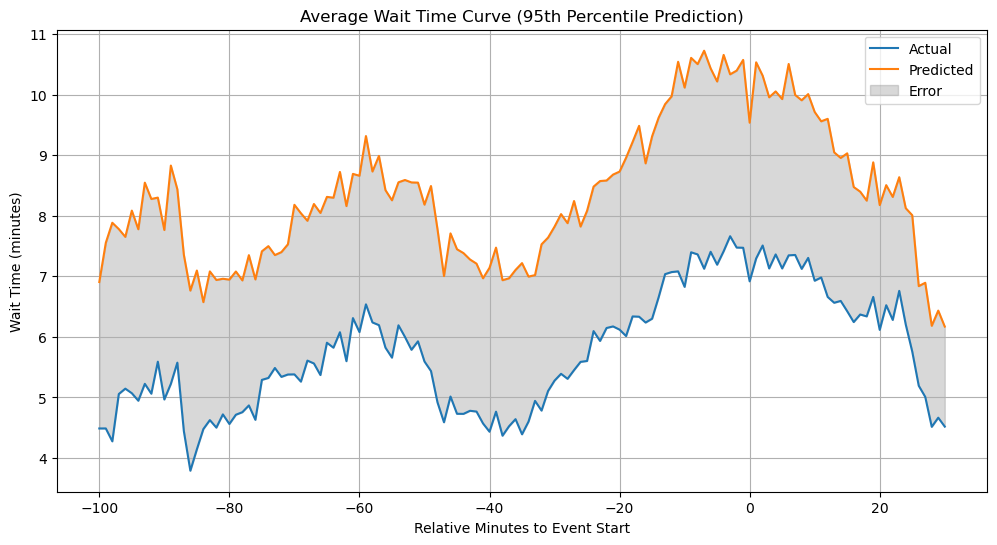

In [41]:
curve_eval = (
    df_test.groupby('relative start (minutes)')
           .agg(actual=(target, 'mean'),
                predicted=('predicted', 'mean'),
                count=('event_name', 'count'))
           .reset_index()
)
curve_eval['error'] = np.abs(curve_eval['actual'] - curve_eval['predicted'])

# Plot curve
plt.figure(figsize=(12, 6))
plt.plot(curve_eval['relative start (minutes)'], curve_eval['actual'], label='Actual')
plt.plot(curve_eval['relative start (minutes)'], curve_eval['predicted'], label='Predicted')
plt.fill_between(curve_eval['relative start (minutes)'],
                 curve_eval['actual'], curve_eval['predicted'],
                 color='gray', alpha=0.3, label='Error')
plt.title("Average Wait Time Curve (95th Percentile Prediction)")
plt.xlabel("Relative Minutes to Event Start")
plt.ylabel("Wait Time (minutes)")
plt.legend()
plt.grid()
plt.show()


In [42]:
# Select core columns to inspect
error_diagnostics = df_test[
    ['event_name', 'event_date', 'relative start (minutes)', 'wait time (minutes)', 'predicted', 'error']
    + features  # append all feature columns
].sort_values(by='error', ascending=False)

# Show top 20 worst predictions
print(error_diagnostics.head(20))


       event_name  event_date  relative start (minutes)  wait time (minutes)  \
112649   24BA0617  2024-06-17                       -66                  0.5   
207130   24LB0820  2024-08-20                         1                  0.5   
209073   24LB0905  2024-09-05                       -58                  0.5   
89570    24BA0218  2024-02-18                         1                  0.5   
209079   24LB0905  2024-09-05                       -57                  1.0   
206737   24LB0820  2024-08-20                       -62                  0.5   
112643   24BA0617  2024-06-17                       -67                  0.5   
89518    24BA0218  2024-02-18                        -6                  0.5   
89466    24BA0218  2024-02-18                       -12                  1.0   
116155   24BA0701  2024-07-01                         6                  1.0   
89603    24BA0218  2024-02-18                         6                  0.5   
69400    23BK1112  2023-11-12           

In [43]:
error_diagnostics.to_csv('error_diagnostics_v3_barclays_gb.csv', index=False)

In [44]:
error_diagnostics.columns.tolist()

['event_name',
 'event_date',
 'relative start (minutes)',
 'wait time (minutes)',
 'predicted',
 'error',
 'relative start (minutes)',
 'event_day',
 'team',
 'minor_category',
 'time category',
 '5_minute_bucket',
 'queue_mean_3',
 'queue_slope_3',
 'hour',
 'hour_sin',
 'hour_cos',
 'day_sin',
 'day_cos',
 'minute_sin',
 'minute_cos',
 'count',
 'temperature_2m_max',
 'temperature_2m_min',
 'precipitation_sum',
 'minute_minor_interaction',
 'minute_sq',
 'property_minor_interaction',
 'log_queue_max10',
 'other_events',
 'concurrent_event']

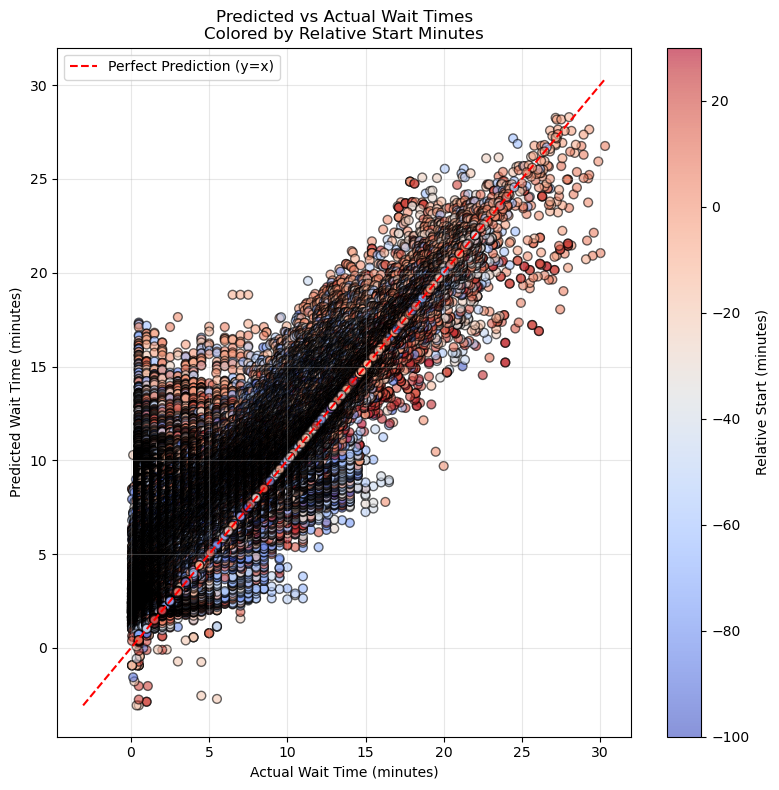

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Scatter plot: actual vs predicted
sc = plt.scatter(
    error_diagnostics['wait time (minutes)'],
    error_diagnostics['predicted'],
    c=error_diagnostics['5_minute_bucket'],
    cmap='coolwarm',
    alpha=0.6,
    edgecolor='k',
    s=40
)

# Slope=1 reference line
min_val = min(error_diagnostics['wait time (minutes)'].min(), error_diagnostics['predicted'].min())
max_val = max(error_diagnostics['wait time (minutes)'].max(), error_diagnostics['predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction (y=x)')

# Labels and colorbar
plt.xlabel('Actual Wait Time (minutes)')
plt.ylabel('Predicted Wait Time (minutes)')
plt.title('Predicted vs Actual Wait Times\nColored by Relative Start Minutes')
plt.colorbar(sc, label='Relative Start (minutes)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


by minute

In [20]:
# Compute Mean Absolute Error per 5_minute_bucket
mae_by_minute = (
    df_test.groupby('relative start (minutes)')['error']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'mae', 'count': 'n_obs'})
    .reset_index()
)

C:\Users\spark\AppData\Local\Temp\ipykernel_17956\393886287.py:15: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\spark\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


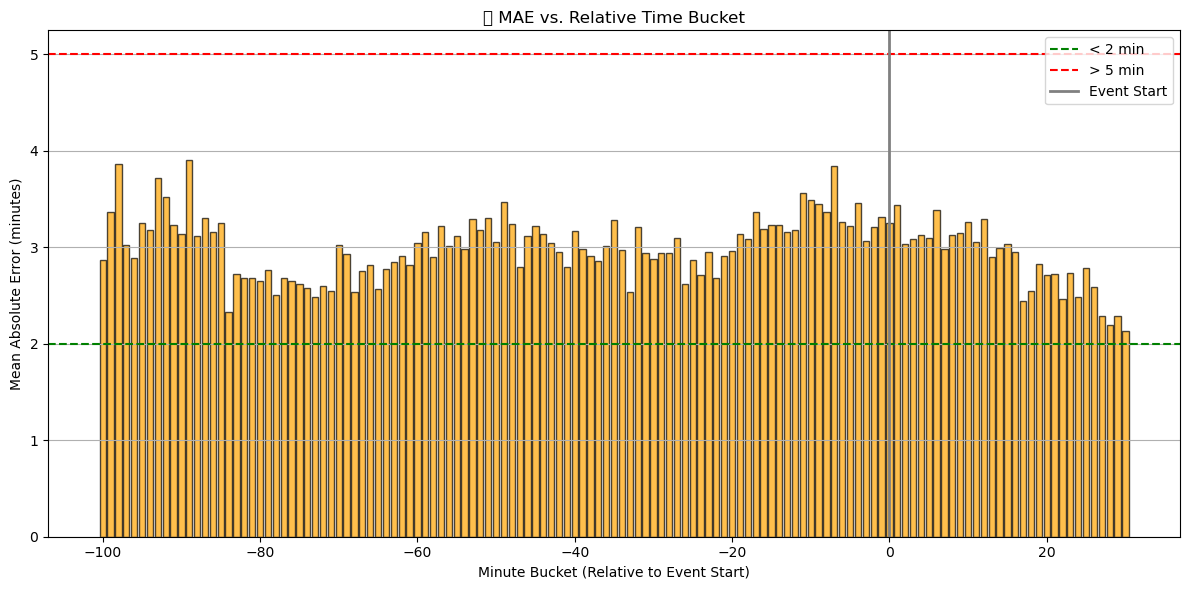

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(mae_by_minute['relative start (minutes)'], mae_by_minute['mae'], 
        color='orange', edgecolor='black', alpha=0.7)
plt.axhline(y=2, color='green', linestyle='--', label='< 2 min')
plt.axhline(y=5, color='red', linestyle='--', label='> 5 min')
plt.axvline(x=0, color='gray', linestyle='-', linewidth=2, label='Event Start')

plt.xlabel('Minute Bucket (Relative to Event Start)')
plt.ylabel('Mean Absolute Error (minutes)')
plt.title('📉 MAE vs. Relative Time Bucket')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### by 5 minute bucket 

In [22]:
# Compute Mean Absolute Error per 5_minute_bucket
mae_by_5_minute = (
    df_test.groupby('5_minute_bucket')['error']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'mae', 'count': 'n_obs'})
    .reset_index()
)

C:\Users\spark\AppData\Local\Temp\ipykernel_17956\3699128270.py:15: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\spark\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


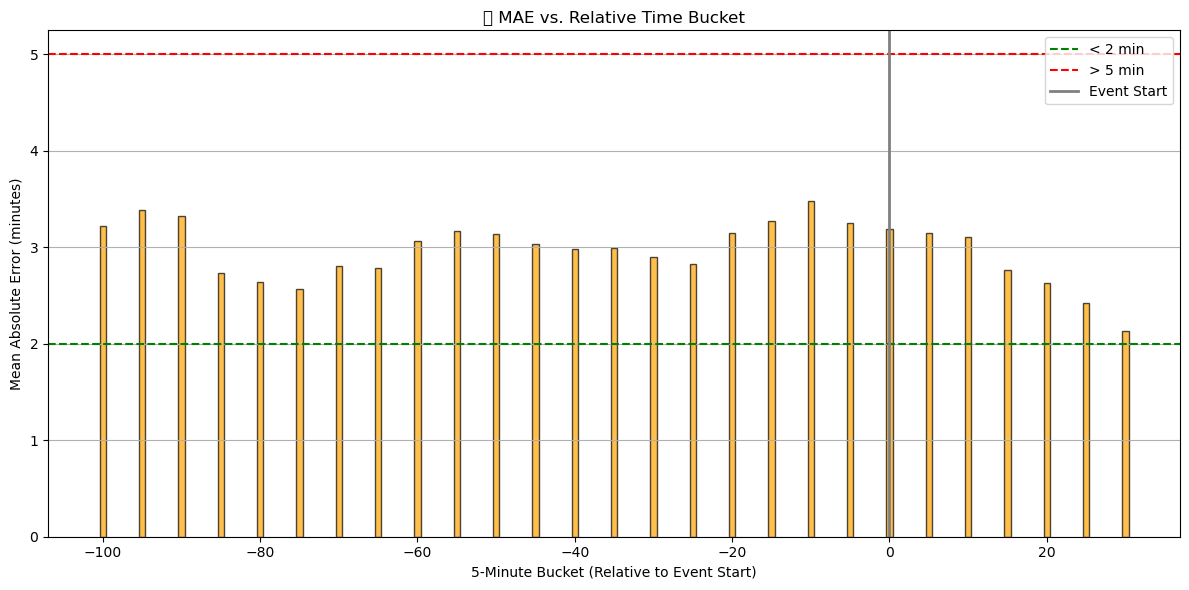

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(mae_by_5_minute['5_minute_bucket'], mae_by_5_minute['mae'], 
        color='orange', edgecolor='black', alpha=0.7)
plt.axhline(y=2, color='green', linestyle='--', label='< 2 min')
plt.axhline(y=5, color='red', linestyle='--', label='> 5 min')
plt.axvline(x=0, color='gray', linestyle='-', linewidth=2, label='Event Start')

plt.xlabel('5-Minute Bucket (Relative to Event Start)')
plt.ylabel('Mean Absolute Error (minutes)')
plt.title('📉 MAE vs. Relative Time Bucket')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Confidence Interval

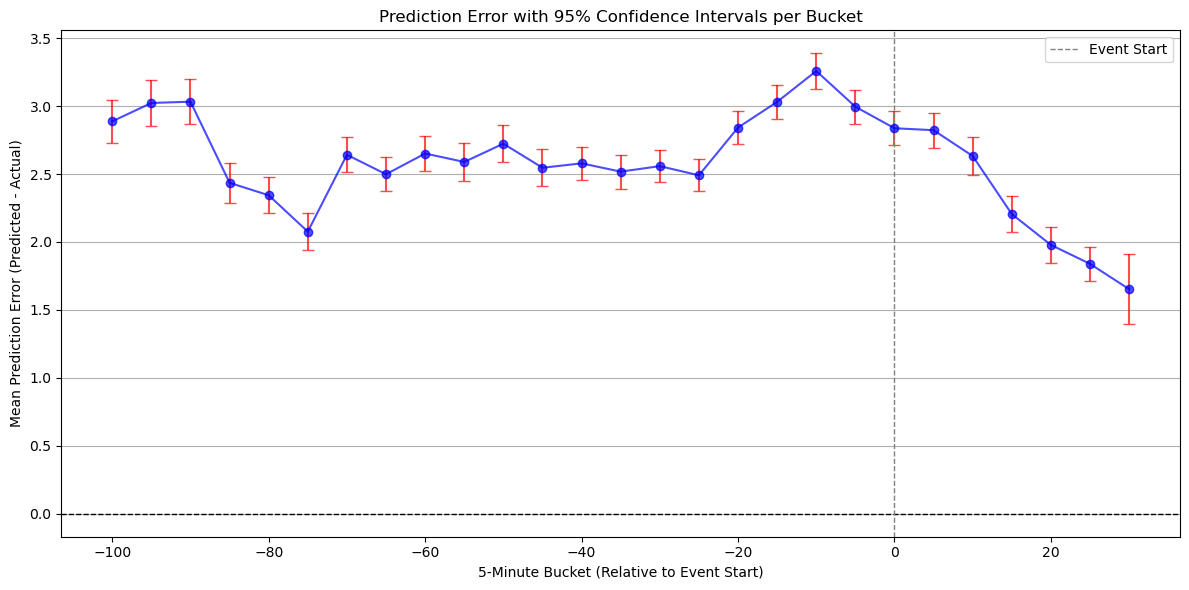

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute residuals
df_test['residual'] = df_test['predicted'] - df_test['wait time (minutes)']

# Group by bucket and calculate stats
ci_stats = df_test.groupby('5_minute_bucket').agg(
    mean_residual=('residual', 'mean'),
    std_residual=('residual', 'std'),
    n_obs=('residual', 'count')
).reset_index()

# Compute 95% CI bounds: mean ± 1.96 * (std / sqrt(n))
ci_stats['ci_lower'] = ci_stats['mean_residual'] - 1.96 * (ci_stats['std_residual'] / np.sqrt(ci_stats['n_obs']))
ci_stats['ci_upper'] = ci_stats['mean_residual'] + 1.96 * (ci_stats['std_residual'] / np.sqrt(ci_stats['n_obs']))

# Plot
plt.figure(figsize=(12,6))
plt.errorbar(
    ci_stats['5_minute_bucket'],
    ci_stats['mean_residual'],
    yerr=1.96 * (ci_stats['std_residual'] / np.sqrt(ci_stats['n_obs'])),
    fmt='o-', ecolor='red', capsize=4, color='blue', alpha=0.7
)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axvline(0, color='gray', linestyle='--', linewidth=1, label='Event Start')
plt.xlabel('5-Minute Bucket (Relative to Event Start)')
plt.ylabel('Mean Prediction Error (Predicted - Actual)')
plt.title('Prediction Error with 95% Confidence Intervals per Bucket')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


high mean error and narrow CI -- higher training weight to reduce bias 

high mean error and wide CI -- inconsistent error 

##### SHAP

In [24]:
import shap
import numpy as np

def shap_explain_worst(model, df_test, top_k=20):
    # Copy and calculate error
    df_test = df_test.copy()
    df_test['error'] = np.abs(df_test['wait time (minutes)'] - df_test['predicted'])

    # Select worst predictions
    worst = df_test.sort_values(by='error', ascending=False).head(top_k)

    # Pick one minute bucket's model
    minute = worst.iloc[0]['relative start (minutes)']
    reg = model.models[minute][model.quantiles[0]]

    # Get feature names
    cat_names = model.preprocessor.named_transformers_['cat'].get_feature_names_out()
    num_names = model.preprocessor.named_transformers_['num'].get_feature_names_out()
    feature_names = np.concatenate([num_names, cat_names])

    # Transform data (convert sparse to dense arrays)
    X_all_transformed = model.preprocessor.transform(df_test[model.feature_columns])
    if not isinstance(X_all_transformed, np.ndarray):
        X_all_transformed = X_all_transformed.toarray()

    X_worst_transformed = model.preprocessor.transform(worst[model.feature_columns])
    if not isinstance(X_worst_transformed, np.ndarray):
        X_worst_transformed = X_worst_transformed.toarray()

    # Sample background for SHAP
    background = shap.sample(X_all_transformed, 50, random_state=42)

    # TreeExplainer for GradientBoostingRegressor
    explainer = shap.TreeExplainer(
        reg,
        background,
        feature_names=feature_names,
        feature_perturbation='interventional'
        )
    shap_values = explainer(X_worst_transformed,  check_additivity=False)

    # Plots
    shap.plots.waterfall(shap_values[0])
    shap.plots.bar(shap_values)


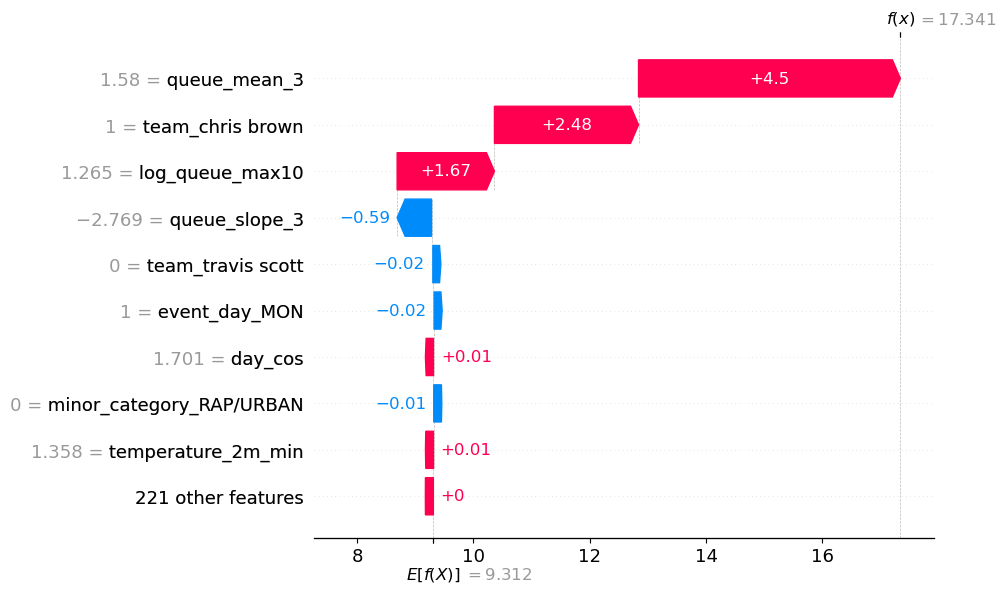

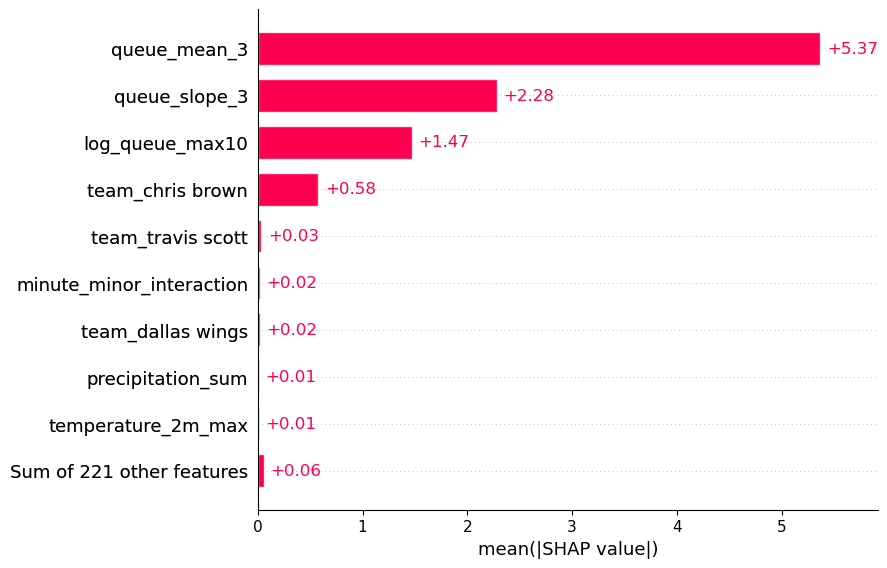

In [25]:
shap_explain_worst(model_gb, df_test, top_k=20)

##### Feature Importance 

In [26]:
def aggregate_feature_importance(model):
    importances = []

    for minute, models in model.models.items():
        for quantile, reg in models.items():
            if hasattr(reg, 'feature_importances_'):
                importances.append(reg.feature_importances_)

    if not importances:
        raise ValueError("No models with feature_importances_ found.")

    importances = np.array(importances)
    mean_importance = np.mean(importances, axis=0)

    # Get expanded feature names from preprocessor
    try:
        cat_names = model.preprocessor.named_transformers_['cat'].get_feature_names_out()
        num_names = model.preprocessor.named_transformers_['num'].get_feature_names_out()
        all_feature_names = np.concatenate([num_names, cat_names])
    except:
        raise ValueError("Could not extract feature names from preprocessor")

    return pd.DataFrame({
        'feature': all_feature_names,
        'importance': mean_importance
    }).sort_values(by='importance', ascending=False)


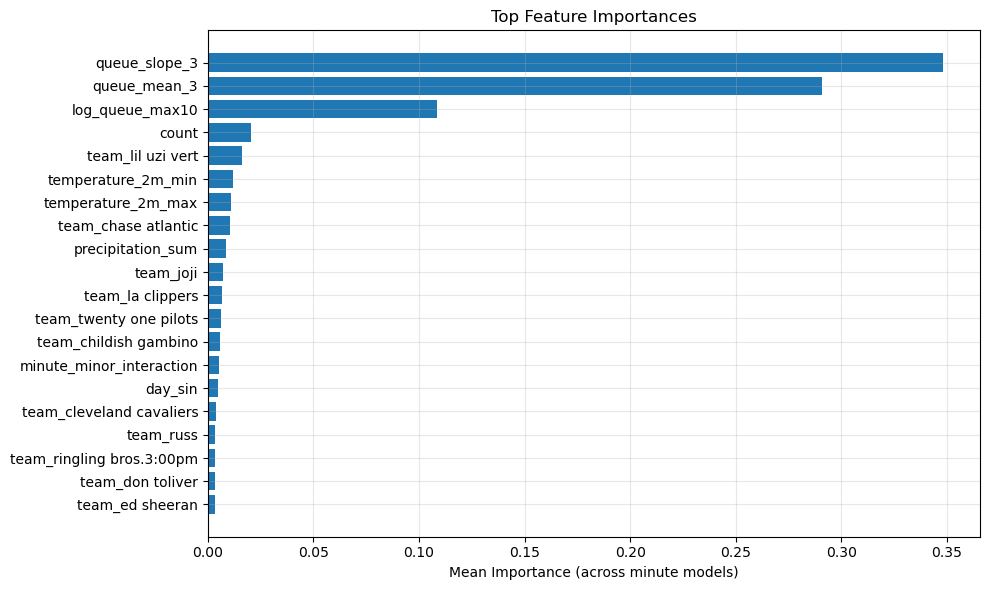

In [27]:
importance_df = aggregate_feature_importance(model_gb)

# Optional: Plot top 20
top_n = 20
plt.figure(figsize=(10, 6))
plt.barh(importance_df.head(top_n)['feature'][::-1], importance_df.head(top_n)['importance'][::-1])
plt.title("Top Feature Importances")
plt.xlabel("Mean Importance (across minute models)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


##### per minute feature

In [32]:
# def feature_importance_by_minute(model):
#     rows = []

#     # Get expanded feature names
#     cat_names = model.preprocessor.named_transformers_['cat'].get_feature_names_out()
#     num_names = model.preprocessor.named_transformers_['num'].get_feature_names_out()
#     all_feature_names = np.concatenate([num_names, cat_names])

#     for minute, model_dict in model.models.items():
#         q = model.quantiles[0]
#         if q in model_dict:
#             reg = model_dict[q]
#             if hasattr(reg, 'feature_importances_'):
#                 rows.append(pd.DataFrame({
#                     'minute': minute,
#                     'feature': all_feature_names,
#                     'importance': reg.feature_importances_
#                 }))
    
#     return pd.concat(rows, ignore_index=True)


##### MAE per 5minute 

In [31]:
# Count data points per bucket
counts = df_test.groupby('5_minute_bucket').size().rename('count')

# Calculate MAE per bucket
mae_per_bucket = abs(df_test['wait time (minutes)'] - df_test['predicted']).groupby(df_test['5_minute_bucket']).mean().rename('mae')

# Merge
bucket_stats = pd.concat([counts, mae_per_bucket], axis=1).reset_index()

# Normalize count
bucket_stats['count_pct'] = bucket_stats['count'] / bucket_stats['count'].sum()

# Optional: weight suggestion = mae / count_pct
bucket_stats['weight_suggestion'] = bucket_stats['mae'] / bucket_stats['count_pct']

print(bucket_stats.sort_values('weight_suggestion', ascending=False))

    5_minute_bucket  count       mae  count_pct  weight_suggestion
26               30    325  2.131204   0.007259         293.601263
1               -95    883  3.382692   0.019722         171.521247
0              -100    905  3.221209   0.020213         159.362638
2               -90    938  3.324236   0.020950         158.673779
3               -85    990  2.732209   0.022112         123.564826
4               -80   1099  2.645684   0.024546         107.784552
5               -75   1333  2.566660   0.029772          86.209350
10              -50   1766  3.137333   0.039443          79.540094
6               -70   1582  2.808929   0.035334          79.496947
9               -55   1838  3.172424   0.041052          77.279071
11              -45   1761  3.035660   0.039332          77.180919
12              -40   1764  2.983533   0.039399          75.726605
8               -60   1825  3.067549   0.040761          75.256638
18              -10   2123  3.484164   0.047417          73.47

#### Light GB

In [46]:
model_lgb = WaitTimeQuantileCurveRegressor(quantiles=[0.95], model_type='lightgbm')
model_lgb.fit(
    df=df_train,
    feature_columns=features,
    target_column=target,
    group_column='relative start (minutes)',
    preprocessor=preprocessor
)

In [47]:
df_test = df.iloc[test_idx].copy()
df_test['predicted'] = model_lgb.predict_curve(df_test)
df_test['error'] = np.abs(df_test[target] - df_test['predicted']) #abs error 